In [1]:
# -*- coding: utf-8 -*-
"""Project.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1QuW_nvpJw-As9udxUYcJ8sRFAc9vVx7T
"""

# all imports
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
"""**Storing Movie Data**"""

# Load movie catalogue
df_movie_data = pd.read_csv('movie_titles.csv', sep=',', header=None, names=['Movie_Id', 'Release_Year', 'Movie_Name'],
                            usecols=[0, 1, 2], encoding="ISO-8859-1")

# Setting index value for the movie data
df_movie_data.set_index('Movie_Id', inplace=True)

In [3]:
df_movie_data.head()


,Release_Year,Movie_Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


Distribution of Movies by Release Year


In [9]:
print(df_movie_data['Release_Year'].isna().sum())


0


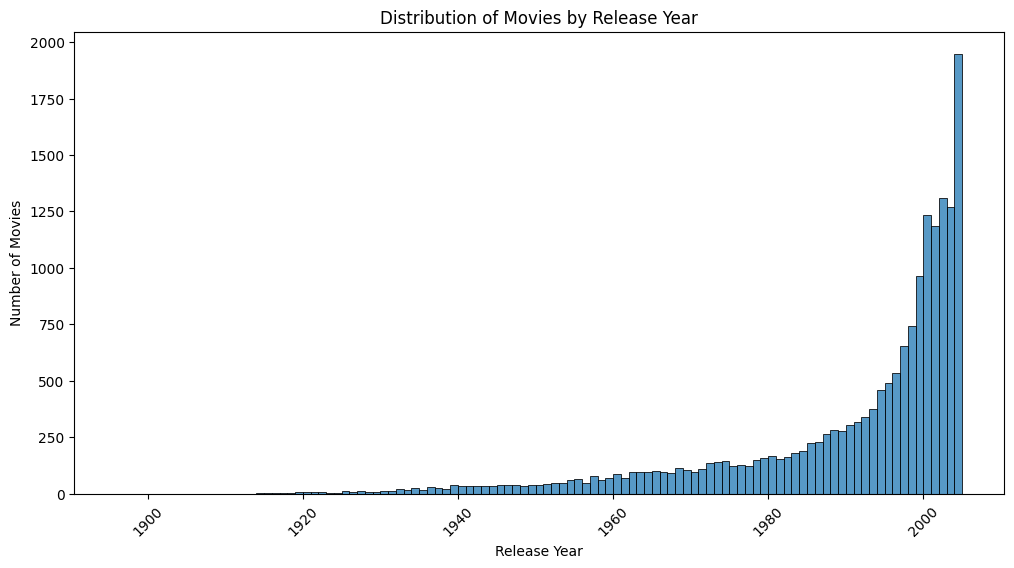

In [10]:


df_movie_data['Release_Year'] = df_movie_data['Release_Year'].astype(int)
plt.figure(figsize=(12, 6))
sns.histplot(df_movie_data['Release_Year'], bins=range(df_movie_data['Release_Year'].min(), df_movie_data['Release_Year'].max() + 1), kde=False)
plt.title('Distribution of Movies by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

In [5]:
"""**Storing Customer reviews data**"""

df_ratings = pd.DataFrame()

for _f in ["combined_data_1.txt", "combined_data_2.txt", "combined_data_3.txt", "combined_data_4.txt"]:
    temp = pd.read_csv('' + _f, header=None, names=['Cust_Id', 'Rating'], usecols=[0, 1])
    temp['Rating'] = temp['Rating'].astype(float)

    print("{} shape: {}".format(_f, temp.shape))

    if len(df_ratings) >= 0:
        df_ratings = pd.concat([df_ratings, temp], ignore_index=True)
    del temp

print("df_ratings = " , df_ratings)

combined_data_1.txt shape: (24058263, 2)
combined_data_2.txt shape: (26982302, 2)
combined_data_3.txt shape: (22605786, 2)
combined_data_4.txt shape: (26851926, 2)
df_ratings =             Cust_Id  Rating
0               1:     NaN
1          1488844     3.0
2           822109     5.0
3           885013     4.0
4            30878     4.0
...            ...     ...
100498272  1790158     4.0
100498273  1608708     3.0
100498274   234275     1.0
100498275   255278     4.0
100498276   453585     2.0

[100498277 rows x 2 columns]


In [6]:
"""**Removing the values NAN and adding a new column of movie_Ids**"""

movies_IDs = pd.DataFrame(pd.isnull(df_ratings.Rating))
movies_IDs = movies_IDs[movies_IDs['Rating'] == True]
movies_IDs = movies_IDs.reset_index()
print("movies_IDs - " , movies_IDs)

total_movies_IDs = []
movie_counter = 1
for i, j in zip(movies_IDs['index'][1:], movies_IDs['index'][:-1]):
    temp = np.full((1, i - j - 1), movie_counter)
    total_movies_IDs = np.append(total_movies_IDs, temp)
    movie_counter += 1

# handle last row
last_row = np.full((1, len(df_ratings) - movies_IDs.iloc[-1, 0] - 1), movie_counter)
total_movies_IDs = np.append(total_movies_IDs, last_row)
print("total_movies_IDs = " , total_movies_IDs)

df_ratings = df_ratings[pd.notnull(df_ratings['Rating'])]
print('Movie IDs array shape: {}'.format(df_ratings.shape))
print('Movie IDs array shape: {}'.format(total_movies_IDs.shape))

print("df_ratings1 - " , df_ratings)

df_ratings['Movie_Id'] = total_movies_IDs.astype(int)
df_ratings['Cust_Id'] = df_ratings['Cust_Id'].astype(int)

print("df_ratings.info - " , df_ratings.info)    

movies_IDs -             index  Rating
0              0    True
1            548    True
2            694    True
3           2707    True
4           2850    True
...          ...     ...
17765  100488431    True
17766  100489037    True
17767  100489242    True
17768  100490605    True
17769  100497355    True

[17770 rows x 2 columns]
total_movies_IDs =  [1.000e+00 1.000e+00 1.000e+00 ... 1.777e+04 1.777e+04 1.777e+04]
Movie IDs array shape: (100480507, 2)
Movie IDs array shape: (100480507,)
df_ratings1 -             Cust_Id  Rating
1          1488844     3.0
2           822109     5.0
3           885013     4.0
4            30878     4.0
5           823519     3.0
...            ...     ...
100498272  1790158     4.0
100498273  1608708     3.0
100498274   234275     1.0
100498275   255278     4.0
100498276   453585     2.0

[100480507 rows x 2 columns]
df_ratings.info -  <bound method DataFrame.info of            Cust_Id  Rating  Movie_Id
1          1488844     3.0         1
2     

In [7]:
"""**Checking for missing values and duplicated values**"""

print(df_ratings.isnull().sum())

print(df_ratings.duplicated().sum())



Cust_Id     0
Rating      0
Movie_Id    0
dtype: int64
0


Distribution of Movie Ratings

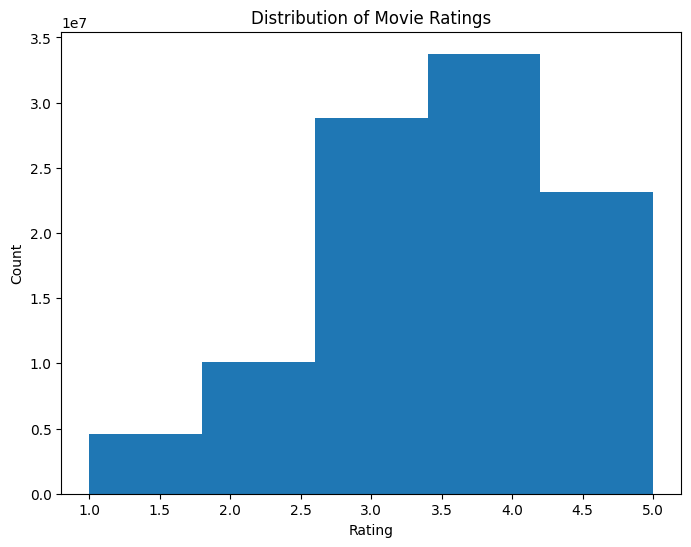

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(df_ratings['Rating'], bins=5)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

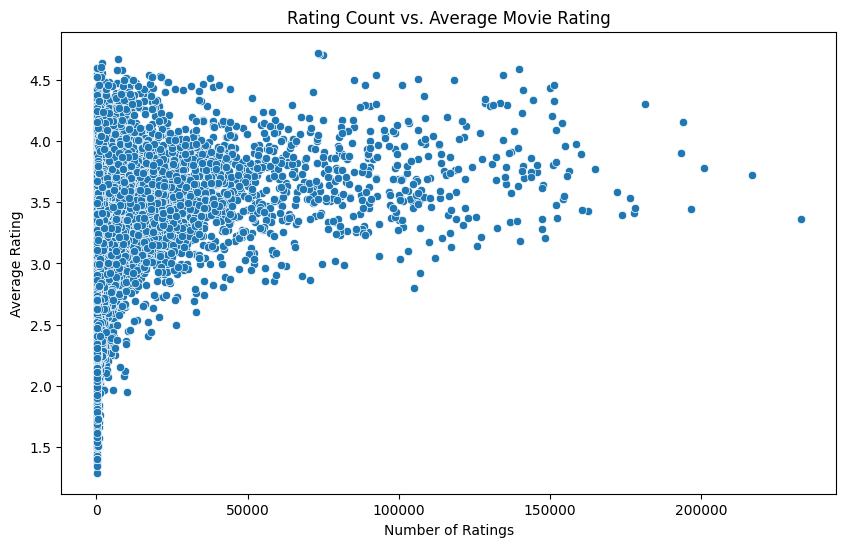

In [12]:
movie_stats = df_ratings.groupby('Movie_Id').agg({'Rating': ['mean', 'count']})
movie_stats.columns = ['mean_rating', 'rating_count']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating_count', y='mean_rating', data=movie_stats)
plt.title('Rating Count vs. Average Movie Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

In [13]:
"""**Storing it into a matrix**

"""

# Get top N users and M movies based on the number of ratings
top_users = df_ratings['Cust_Id'].value_counts().nlargest(1000).index  # Example: top 1000 users
top_movies = df_ratings['Movie_Id'].value_counts().nlargest(1000).index  # Example: top 1000 movies

filtered_ratings = df_ratings[(df_ratings['Cust_Id'].isin(top_users)) & (df_ratings['Movie_Id'].isin(top_movies))]
user_item_matrix = filtered_ratings.pivot(index='Cust_Id', columns='Movie_Id', values='Rating').fillna(0)
sparse_matrix = csr_matrix(user_item_matrix.values)
print("SM - ", sparse_matrix)


SM -  <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 749617 stored elements and shape (1000, 1000)>
  Coords	Values
  (0, 0)	2.0
  (0, 1)	3.0
  (0, 2)	2.0
  (0, 3)	4.0
  (0, 4)	3.0
  (0, 5)	1.0
  (0, 6)	2.0
  (0, 7)	3.0
  (0, 8)	3.0
  (0, 12)	4.0
  (0, 14)	1.0
  (0, 15)	3.0
  (0, 16)	3.0
  (0, 17)	3.0
  (0, 19)	2.0
  (0, 20)	3.0
  (0, 21)	5.0
  (0, 22)	3.0
  (0, 23)	3.0
  (0, 24)	3.0
  (0, 25)	4.0
  (0, 26)	2.0
  (0, 27)	2.0
  (0, 28)	1.0
  (0, 29)	2.0
  :	:
  (999, 972)	5.0
  (999, 973)	4.0
  (999, 974)	5.0
  (999, 975)	3.0
  (999, 977)	3.0
  (999, 978)	4.0
  (999, 979)	5.0
  (999, 981)	5.0
  (999, 982)	4.0
  (999, 983)	4.0
  (999, 984)	4.0
  (999, 985)	3.0
  (999, 987)	3.0
  (999, 988)	4.0
  (999, 989)	5.0
  (999, 990)	4.0
  (999, 991)	4.0
  (999, 992)	4.0
  (999, 993)	3.0
  (999, 994)	5.0
  (999, 995)	3.0
  (999, 996)	4.0
  (999, 997)	5.0
  (999, 998)	4.0
  (999, 999)	3.0


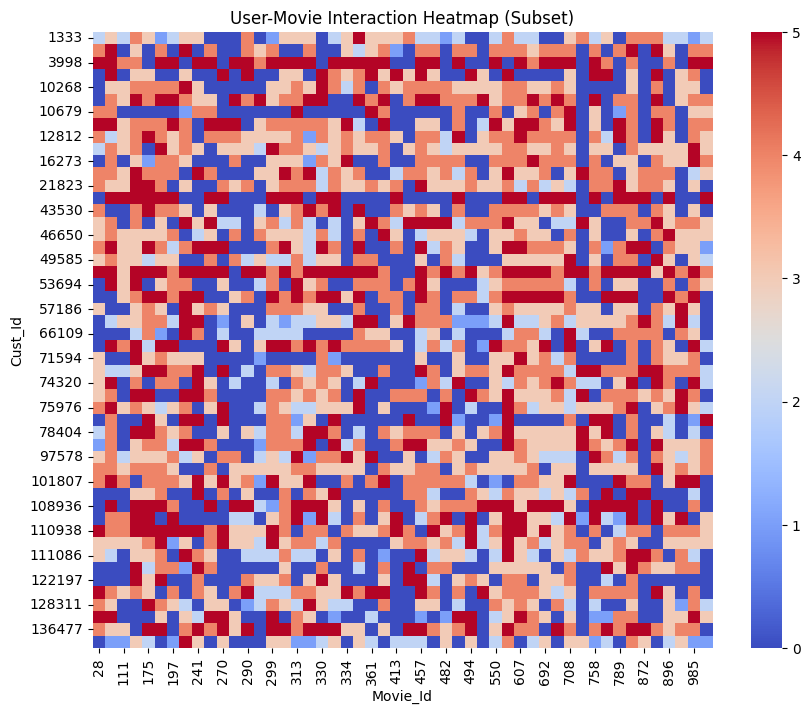

In [14]:


plt.figure(figsize=(10, 8))
sns.heatmap(user_item_matrix.fillna(0).iloc[:50, :50], cmap='coolwarm', cbar=True)
plt.title('User-Movie Interaction Heatmap (Subset)')
plt.show()

In [15]:
# Build the k-NN Model
# Define the number of neighbors (similar users)
n_neighbors = 50

# Instantiate the model using cosine similarity
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbors, n_jobs=-1)
print("knn - ", knn)

# Fit the model on the sparse user-item matrix
knn.fit(sparse_matrix)

#Compute item-item similarity matrix
item_similarity_matrix = cosine_similarity(user_item_matrix.T)

# Convert to DataFrame for easier access
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=user_item_matrix.columns, columns=user_item_matrix.columns)

knn -  NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=50)


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

def calculate_rmse_mae(user_id, recommended_movies, method='user'):
    """
    Calculate RMSE and MAE for the recommended movies.
    """
    # Get the movies that the user has already rated
    user_ratings = user_item_matrix.loc[user_id]
    
    # Extract the actual ratings of the recommended movies
    actual_ratings = user_ratings.loc[recommended_movies.index]
    
    # Ensure no NaNs are present in the actual ratings (user may not have rated some of the recommended movies)
    actual_ratings = actual_ratings.dropna()

    # Ensure that the predicted ratings align with the actual ratings
    if method == 'user':
        # Using the predicted ratings based on similar users
        predicted_ratings = recommended_movies
    elif method == 'item':
        # Using the predicted ratings based on item similarities
        predicted_ratings = recommended_movies
    else:
        raise ValueError("Method should be either 'user' or 'item'.")
    
    # Filter predicted ratings to only those that the user has actually rated
    predicted_ratings = predicted_ratings.loc[actual_ratings.index]

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(((predicted_ratings - actual_ratings) ** 2).mean())

    # Calculate MAE (Mean Absolute Error)
    mae = (predicted_ratings - actual_ratings).abs().mean()

    return rmse, mae

In [25]:
def recommend_movies(user_id, n_recommendations=15, method='user'):
    if method == 'user':
        # User-based collaborative filtering
        user_index = list(top_users).index(user_id)
        distances, indices = knn.kneighbors(sparse_matrix[user_index], n_neighbors=n_neighbors)
        similar_users = indices.flatten()
        avg_ratings = user_item_matrix.iloc[similar_users].mean(axis=0)

        # Get the movies that the user has not yet rated
        user_rated_movies = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
        recommended_movies = avg_ratings.drop(user_rated_movies).sort_values(ascending=False).head(n_recommendations)

        plt.figure(figsize=(15, 5))
        recommended_movies.plot(kind='bar')
        plt.title(f"Top {n_recommendations} Recommended Movies for User {user_id} (User-Based)")
        plt.xlabel("Movie IDs")
        plt.ylabel("Rating")
        plt.show()

        rmse, mae = calculate_rmse_mae(user_id, recommended_movies, method)
        print(f"RMSE for User {user_id}: {rmse}")
        print(f"MAE for User {user_id}: {mae}")

    elif method == 'item':
        # Item-based collaborative filtering
        user_rated_items = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
        similar_items = item_similarity_df[user_rated_items].mean(axis=1)  # Average similarity for rated items

        # Exclude already rated movies
        recommended_movies = similar_items.drop(user_rated_items).sort_values(ascending=False).head(n_recommendations)

        plt.figure(figsize=(15, 5))
        recommended_movies.plot(kind='bar')
        plt.title(f"Top {n_recommendations} Recommended Movies for User {user_id} (Item-Based)")
        plt.xlabel("Movie IDs")
        plt.ylabel("Similarity Score")
        plt.show()

        rmse, mae = calculate_rmse_mae(user_id, recommended_movies, method)
        print(f"RMSE for User {user_id}: {rmse}")
        print(f"MAE for User {user_id}: {mae}")

    else:
        raise ValueError("Method should be either 'user' or 'item'.")

    return recommended_movies


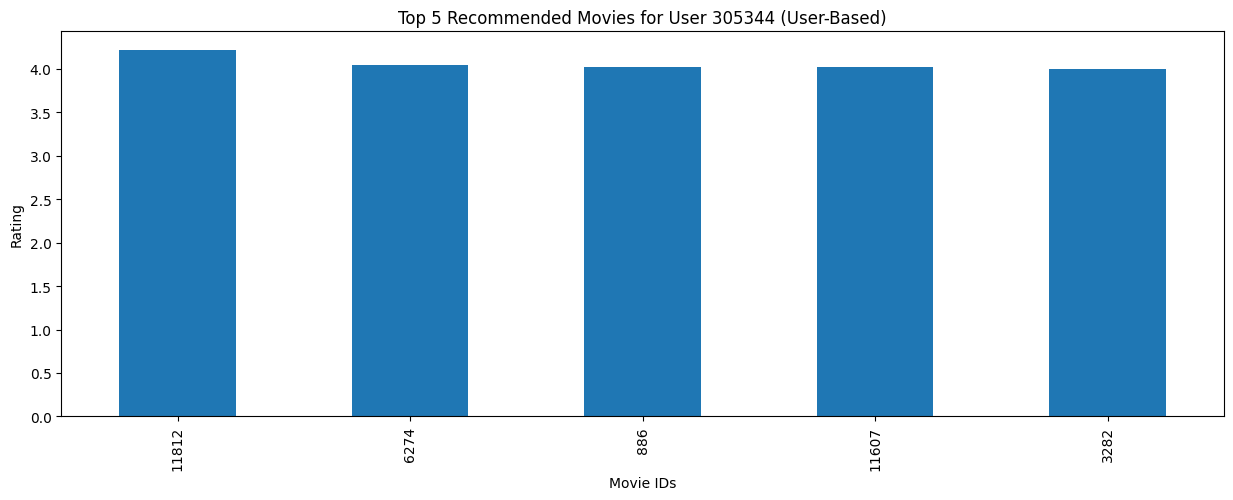

RMSE for User 305344: 4.060807801410945
MAE for User 305344: 4.06
User-based recommendations for user 305344: 
Movie_Id
11812    4.22
6274     4.04
886      4.02
11607    4.02
3282     4.00
dtype: float64


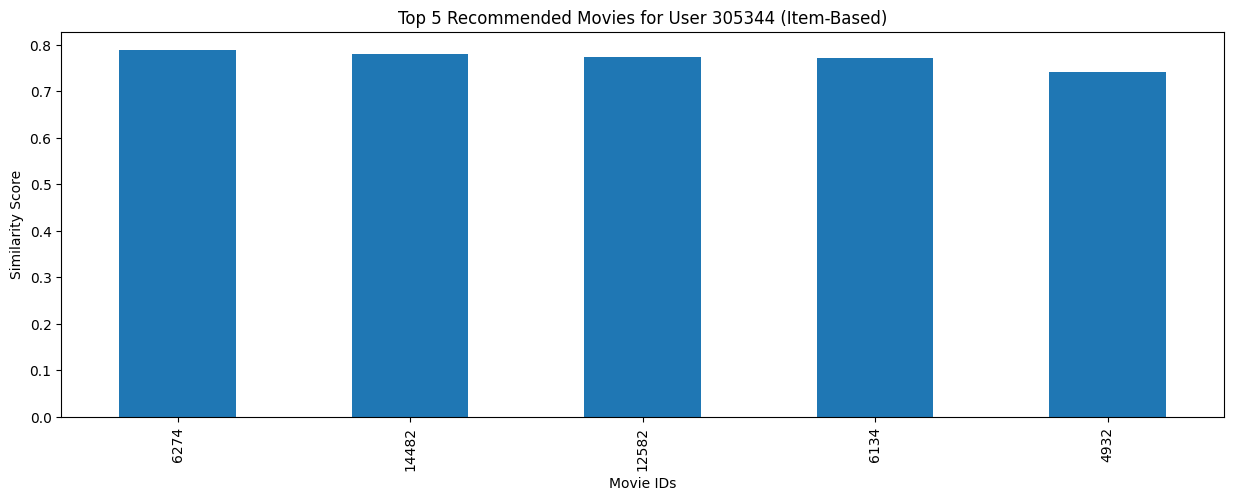

RMSE for User 305344: 0.7710333688310052
MAE for User 305344: 0.7708666142617482
Item-based recommendations for user 305344: 
Movie_Id
6274     0.788387
14482    0.779583
12582    0.773252
6134     0.772167
4932     0.740945
dtype: float64


In [26]:
#Testing
# Example:
user_id = top_users[0]  # Example user from the top 1000 users

# Get user-based recommendations - gives the movies recommended, along with the predicted rating based on similar users
user_recommendations = recommend_movies(user_id, n_recommendations=5, method='user')
print("User-based recommendations for user {}: \n{}".format(user_id, user_recommendations))

# Get item-based recommendations - gives the movies recommended, along with their similarity scores (how similar they are to the movies user x has rated)
item_recommendations = recommend_movies(user_id, n_recommendations=5, method='item')
print("Item-based recommendations for user {}: \n{}".format(user_id, item_recommendations))


SVD

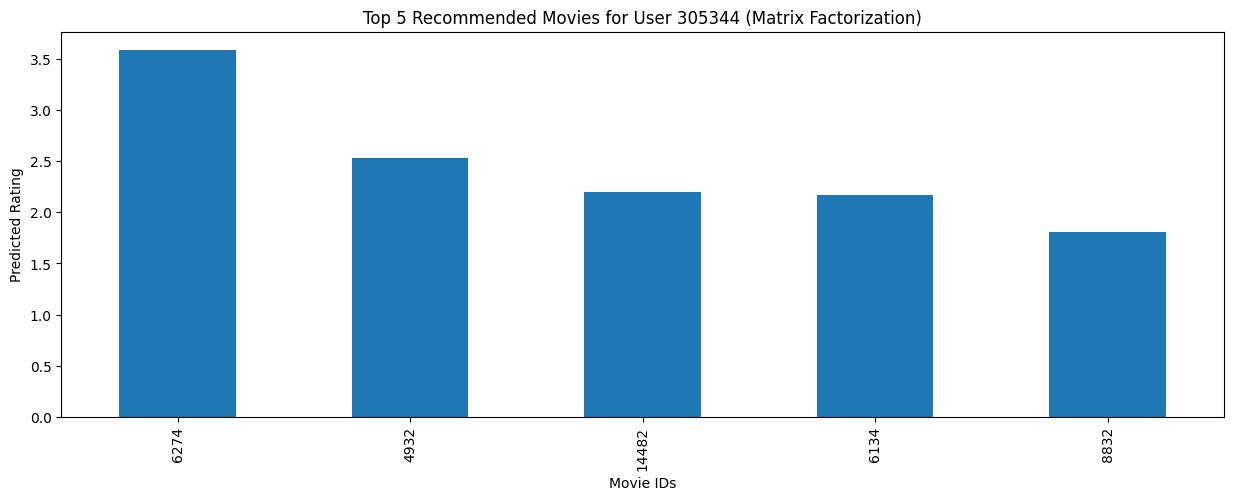

Matrix Factorization-based recommendations for user 305344:
Movie_Id
6274     3.587648
4932     2.534829
14482    2.199819
6134     2.173632
8832     1.809733
Name: 305344, dtype: float64


In [38]:
from scipy.sparse.linalg import svds

n_latent_factors = 200
U, sigma, Vt = svds(sparse_matrix, k=n_latent_factors)
sigma = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma), Vt)
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)

# Function to get movie recommendations for a user based on SVD
def recommend_movies_svd(user_id, n_recommendations=5):
    user_predictions = predicted_ratings_df.loc[user_id].sort_values(ascending=False)

    rated_movies = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    recommended_movies = user_predictions.drop(rated_movies, errors='ignore').head(n_recommendations)

    plt.figure(figsize=(15, 5))
    recommended_movies.plot(kind='bar')
    plt.title(f"Top {n_recommendations} Recommended Movies for User {user_id} (Matrix Factorization)")
    plt.xlabel("Movie IDs")
    plt.ylabel("Predicted Rating")
    plt.show()

    return recommended_movies

# Test
user_id = top_users[0]  
recommendations = recommend_movies_svd(user_id, n_recommendations=5)
print(f"Matrix Factorization-based recommendations for user {user_id}:\n{recommendations}")

evaluation matrix

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix



# Split data into training and test sets
def train_test_split(user_rating_matrix, test_ratio=0.2):
    train = user_rating_matrix.copy()
    test = pd.DataFrame(0, index=user_rating_matrix.index, columns=user_rating_matrix.columns)

    for user in user_rating_matrix.index:
        rated_items = np.flatnonzero(user_rating_matrix.loc[user].to_numpy())
        if len(rated_items) > 0:
            test_ratings = np.random.choice(rated_items, size=int(test_ratio * len(rated_items)), replace=False)
            train.loc[user, user_rating_matrix.columns[test_ratings]] = 0  
            test.loc[user, user_rating_matrix.columns[test_ratings]] = user_rating_matrix.loc[user, user_rating_matrix.columns[test_ratings]]
    
    return train, test

train_data, test_data = train_test_split(user_item_matrix)

train_data_sparse = csr_matrix(train_data.values)

U, sigma, Vt = svds(train_data_sparse, k=n_latent_factors)
sigma = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma), Vt)
train_data = train_data.fillna(0)
predicted_ratings_matrix = pd.DataFrame(predicted_ratings, columns=train_data.columns, index=train_data.index)


# Evaluation metrics
def calculate_metrics(predicted_rating_df, test_matrix):
    test_values = test_data.values[test_matrix.values.nonzero()]
    predicted_values = predicted_rating_df.values[test_matrix.values.nonzero()]

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(test_values, predicted_values)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(test_values, predicted_values))

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
calculate_metrics(predicted_ratings_df, test_data)


Mean Absolute Error (MAE): 0.5932170723328101
Root Mean Squared Error (RMSE): 0.7506134177539144
